Set parameter Username
Set parameter LicenseID to value 2775955
Academic license - for non-commercial use only - expires 2027-02-05
Set parameter LogToConsole to value 0
Set parameter LogToConsole to value 0
Set parameter LogToConsole to value 0
Base Cost:      $ 233000.0
April Promo:    $ 241320.0
January Promo:  $ 230560.0


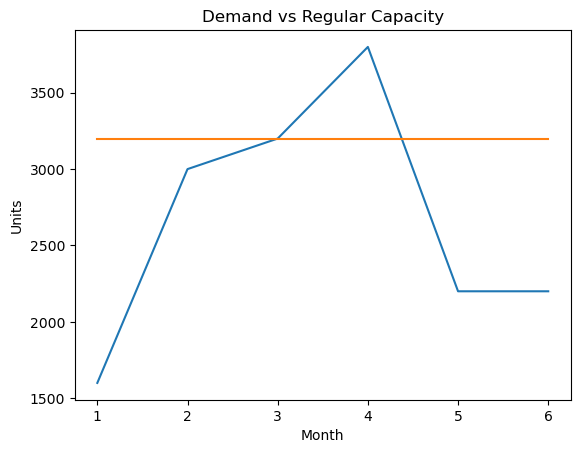

In [1]:
import gurobipy as gp
from gurobipy import GRB

def digital_twin_simulation(demand_scenario):
    """
    Accepts a dictionary of demand {1:val,...,6:val}
    Returns optimized total operating cost
    """

    model = gp.Model("Digital_Twin")
    model.Params.LogToConsole = 0

    T = range(1, 7)

    # -----------------------
    # Parameters
    # -----------------------
    units_per_worker = 160     # regular production per worker per month
    cost_material = 10
    cost_holding = 2
    cost_reg = 4
    cost_ot = 6
    cost_hiring = 300
    cost_layoff = 500

    initial_workforce = 20
    initial_inventory = 0

    # -----------------------
    # Decision Variables
    # -----------------------
    W = model.addVars(T, vtype=GRB.INTEGER, name="Workforce")
    H = model.addVars(T, vtype=GRB.INTEGER, name="Hiring")
    L = model.addVars(T, vtype=GRB.INTEGER, name="Layoff")

    P = model.addVars(T, vtype=GRB.CONTINUOUS, name="Production")
    O = model.addVars(T, vtype=GRB.CONTINUOUS, name="Overtime")
    I = model.addVars(T, vtype=GRB.CONTINUOUS, name="Inventory")

    # -----------------------
    # Constraints
    # -----------------------

    for t in T:
        # Workforce balance
        if t == 1:
            model.addConstr(
                W[t] == initial_workforce + H[t] - L[t]
            )
        else:
            model.addConstr(
                W[t] == W[t-1] + H[t] - L[t]
            )

        # Production capacity (regular + overtime)
        model.addConstr(
            P[t] <= units_per_worker * W[t] + O[t]
        )

        # Inventory balance
        if t == 1:
            model.addConstr(
                I[t] == initial_inventory + P[t] - demand_scenario[t]
            )
        else:
            model.addConstr(
                I[t] == I[t-1] + P[t] - demand_scenario[t]
            )

        # No negative inventory
        model.addConstr(I[t] >= 0)

    # -----------------------
    # Objective: Minimize Cost
    # -----------------------
    total_cost = gp.quicksum(
        cost_material * P[t] +
        cost_holding * I[t] +
        cost_reg * units_per_worker * W[t] +
        cost_ot * O[t] +
        cost_hiring * H[t] +
        cost_layoff * L[t]
        for t in T
    )

    model.setObjective(total_cost, GRB.MINIMIZE)
    model.optimize()

    return model.ObjVal


# ============================
# RUN SCENARIOS
# ============================

base = {1:1600, 2:3000, 3:3200, 4:3800, 5:2200, 6:2200}

# April Promotion
dem_apr = base.copy()
dem_apr[4] = base[4] * 1.20
dem_apr[5] = base[5] * 0.85

# January Promotion
dem_jan = base.copy()
dem_jan[1] = base[1] * 1.20
dem_jan[2] = base[2] * 0.85


cost_base = digital_twin_simulation(base)
cost_apr  = digital_twin_simulation(dem_apr)
cost_jan  = digital_twin_simulation(dem_jan)

print("Base Cost:      $", round(cost_base,2))
print("April Promo:    $", round(cost_apr,2))
print("January Promo:  $", round(cost_jan,2))



# Graph Interpretation using Matplotlib
# Single plot as required

import matplotlib.pyplot as plt

# Time horizon
months = [1, 2, 3, 4, 5, 6]

# Base demand
demand = [1600, 3000, 3200, 3800, 2200, 2200]

# Assume constant regular workforce of 20 workers
units_per_worker = 160
regular_capacity = [20 * units_per_worker for _ in months]

# Create plot
plt.figure()
plt.plot(months, demand)
plt.plot(months, regular_capacity)

plt.xlabel("Month")
plt.ylabel("Units")
plt.title("Demand vs Regular Capacity")

plt.show()



In [2]:
import gurobipy as gp
from gurobipy import GRB

def digital_twin_simulation(demand_scenario):

    model = gp.Model("Digital_Twin")
    model.Params.LogToConsole = 0

    T = range(1, 7)

    # Parameters
    units_per_worker = 160
    cost_material = 10
    cost_holding = 2
    cost_reg = 4
    cost_ot = 6
    cost_hiring = 300
    cost_layoff = 500

    initial_workforce = 20
    initial_inventory = 0

    # Variables
    W = model.addVars(T, vtype=GRB.INTEGER, name="Workforce")
    H = model.addVars(T, vtype=GRB.INTEGER, name="Hiring")
    L = model.addVars(T, vtype=GRB.INTEGER, name="Layoff")

    P = model.addVars(T, vtype=GRB.CONTINUOUS, name="Production")
    O = model.addVars(T, vtype=GRB.CONTINUOUS, name="Overtime")
    I = model.addVars(T, vtype=GRB.CONTINUOUS, name="Inventory")

    # Constraints
    for t in T:

        if t == 1:
            model.addConstr(W[t] == initial_workforce + H[t] - L[t])
            model.addConstr(I[t] == initial_inventory + P[t] - demand_scenario[t])
        else:
            model.addConstr(W[t] == W[t-1] + H[t] - L[t])
            model.addConstr(I[t] == I[t-1] + P[t] - demand_scenario[t])

        model.addConstr(P[t] <= units_per_worker * W[t] + O[t])
        model.addConstr(I[t] >= 0)

    # Objective
    total_cost = gp.quicksum(
        cost_material * P[t] +
        cost_holding * I[t] +
        cost_reg * units_per_worker * W[t] +
        cost_ot * O[t] +
        cost_hiring * H[t] +
        cost_layoff * L[t]
        for t in T
    )

    model.setObjective(total_cost, GRB.MINIMIZE)
    model.optimize()

    # Extract overtime
    total_overtime = sum(O[t].X for t in T)

    return {
        "Total Cost": model.ObjVal,
        "Total Overtime Units": total_overtime
    }


In [3]:
base_results = digital_twin_simulation(base)
apr_results  = digital_twin_simulation(dem_apr)
jan_results  = digital_twin_simulation(dem_jan)

print("BASE:", base_results)
print("APRIL PROMO:", apr_results)
print("JAN PROMO:", jan_results)


Set parameter LogToConsole to value 0
Set parameter LogToConsole to value 0
Set parameter LogToConsole to value 0
BASE: {'Total Cost': 233000.0, 'Total Overtime Units': 1360.0}
APRIL PROMO: {'Total Cost': 241320.0, 'Total Overtime Units': 2120.0}
JAN PROMO: {'Total Cost': 230560.0, 'Total Overtime Units': 1240.0}


“Goal: Use pricing to squash the blue line under the red line.”

Your numbers say:

When demand crosses capacity → overtime explodes → profit collapses.

April promo pushes the blue line further above capacity.

January promo smooths it.

So the strategy is:

Raise price in peak months.
Lower price in valley months.
Flatten the curve.

Not increase demand.
Redistribute it.

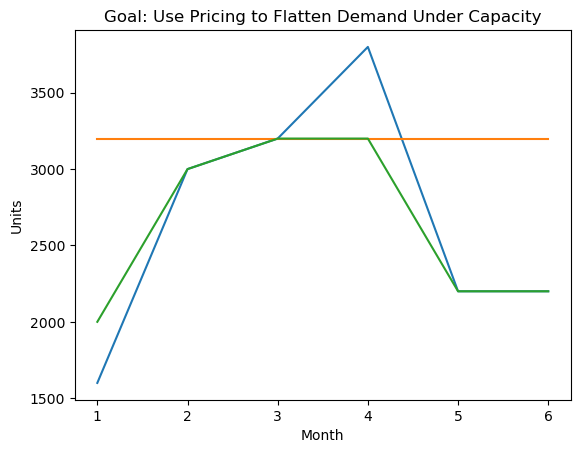

In [4]:
# Matplotlib Visualization: "Squashing the Blue Line" Goal
# Single plot, no specific colors

import matplotlib.pyplot as plt

# Months
months = [1, 2, 3, 4, 5, 6]

# Original demand (Base Case)
demand_original = [1600, 3000, 3200, 3800, 2200, 2200]

# Regular capacity (20 workers × 160 units)
capacity = [3200 for _ in months]

# Smoothed demand scenario (pricing used to flatten peak)
# April reduced to capacity level, excess shifted to January
demand_smoothed = [2000, 3000, 3200, 3200, 2200, 2200]

plt.figure()

plt.plot(months, demand_original)
plt.plot(months, capacity)
plt.plot(months, demand_smoothed)

plt.xlabel("Month")
plt.ylabel("Units")
plt.title("Goal: Use Pricing to Flatten Demand Under Capacity")

plt.show()


## GREEN LINE SHOWS THE GOAL 
## RED LINE IS THE CAPACITY
## BLUE LINE IS THEINITIAL DEMAND CURVE